

In this task, I trained convolutional neural networks to make classifications on different hand gestures (specifically images of hand gestures), and gathered my own data set.

**American Sign Language**

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing.

The hand gestures representing English alphabet are shown below. Specifically, given an image of a hand showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

In [ ]:
_ = !unzip "/content/Hand_Gesture_Dataset_revised.zip" -d "/content/Hand_Gesture_Dataset_revised/"

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import random
from torch.utils.data.sampler import SubsetRandomSampler
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split

def get_data_loader(data_dir, batch_size, test_split=0.18, valid_split=0.22, test_new_hands_ratio=0.02):

  # Define transformations
  transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),         # Convert to Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
  ])

  # Load the full dataset
  dataset = datasets.ImageFolder(data_dir, transform=transform)
  classes = dataset.classes  # Get class names

  # Split hands
  image_paths = [s[0] for s in dataset.samples]
  hand_dict = {}
  for i, path in enumerate(image_paths):
    hand_id = os.path.basename(path).split('_')[0]
    if hand_id not in hand_dict:
      hand_dict[hand_id] = []
    hand_dict[hand_id].append(i)

  unique_hands = list(hand_dict.keys())

  num_test_new_hands = int(len(unique_hands) * test_new_hands_ratio)
  test_new_hands = random.sample(unique_hands, num_test_new_hands)
  remaining_hands = list(set(unique_hands) - set(test_new_hands))

  if test_split > 0:
    train_hands, test_hands = train_test_split(remaining_hands, test_size=test_split, random_state=42)
  else:
    train_hands, test_hands = remaining_hands, []
  if valid_split > 0:
    train_hands, valid_hands = train_test_split(train_hands, test_size=valid_split, random_state=42)
  else:
    valid_hands = []

  train_indices = [idx for hand in train_hands for idx in hand_dict[hand]]
  valid_indices = [idx for hand in valid_hands for idx in hand_dict[hand]] if valid_hands else []
  test_indices = [idx for hand in test_hands for idx in hand_dict[hand]] if test_hands else []

  if test_split > 0:
    test_indices += [idx for hand in test_new_hands for idx in hand_dict[hand]]

  train_dataset, val_dataset, test_dataset = Subset(dataset, train_indices), Subset(dataset, valid_indices), Subset(dataset, test_indices)

  # Create DataLoaders
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

  return train_loader, val_loader, test_loader, classes

In [ ]:
# Load the Dataset
data_dir = "./A2_Hand_Gesture_Dataset_revised/Lab_3b_Gesture_Dataset Revised"  # Path to the dataset directory
batch_size = 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    data_dir=data_dir, batch_size=batch_size
)

print(len(train_loader), len(val_loader), len(test_loader))

1519 456 457


In [ ]:
# CNN
class my_CNN(nn.Module):
  def __init__(self):
    super(my_CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 28 * 28, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 9)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

I built a 6-layer CNN: 3 convolutional layers (conv1, conv2, conv3)
 and 3 fully connected layers (fc1, fc2, fc3), which is a balance between complexity and accuracy.
Pooling layers (max pooling) are used after each convolutional layer
 to help reduce the number of parameters and make the network more robust.
ReLU are used as the activation function after each layer (except the last one)
 to introduce non-linearity and help the network learn complex patterns.
The number of channels increases in the conv layers (16->32->64) to learn increasingly complex features.
The numbers of hidden units in fc layers are 256, 128, and 9
 to gradually reduces the dimensionality and finalize the classification.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt

def get_model_name(name, batch_size, learning_rate, epoch):
  path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
  return path

def train(model, train_loader, val_loader, batch_size=64, learning_rate=0.01, num_epochs=1, net_name='CNN'):

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.9)

  train_loss, train_acc, val_loss, val_acc = [], [], [], []

  # training
  for epoch in range(num_epochs):

    running_loss, correct, total = 0, 0, 0

    for i, (imgs, labels) in enumerate(train_loader):

      imgs = imgs.to(device)
      labels = labels.to(device)

      out = model(imgs)        # forward pass
      loss = criterion(out, labels) # compute the total loss
      optimizer.zero_grad()       # a clean up step for PyTorch
      loss.backward()          # backward pass (compute parameter updates)
      optimizer.step()         # make the updates for each parameter

      running_loss += loss.item()

      _, predicted = torch.max(out.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_loss.append(epoch_loss)
    train_acc.append(100 * correct / total)

    correct, total, val_running_loss = 0, 0, 0.0
    with torch.no_grad():
      for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_val_loss = val_running_loss / len(val_loader)
    val_loss.append(epoch_val_loss)
    val_acc.append(100 * correct / total)

    if (epoch+1)%5==0:
      model_file_name = get_model_name(name=net_name, batch_size=batch_size, learning_rate=learning_rate, epoch=epoch)
      model_save_full_path = os.path.join('/content/', model_file_name)
      torch.save(model.state_dict(), model_save_full_path)

  plt.title("Training Curve")
  plt.plot(range(1, num_epochs + 1), train_loss, label="Train")
  plt.plot(range(1, num_epochs + 1), val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Training Curve")
  plt.plot(range(1, num_epochs + 1), train_acc, label="Train")
  plt.plot(range(1, num_epochs + 1), val_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))
  best_epoch = np.argmin(val_loss)
  print("Best epoch: {}".format(best_epoch), "with validation accuracy: {}".format(val_acc[best_epoch]))


The hyperparameters can be given as input when calling the function.
The function checkpointing the models every 5 epochs.
As we are doing a multi-class classification task, cross entropy is the best loss function to choose.
SGD with momentum is used as the optimizer as it can help accelerate the training process and avoid local minima.

In [ ]:
_ = !unzip "/content/my_gesture.zip" -d "/content/my_gesture/"

In [ ]:
data_dir = "./my_gesture"
batch_size = 27
train_loader, val_loader, test_loader, classes = get_data_loader(
    data_dir=data_dir, batch_size=batch_size, test_split=0, valid_split=0, test_new_hands_ratio=0
)

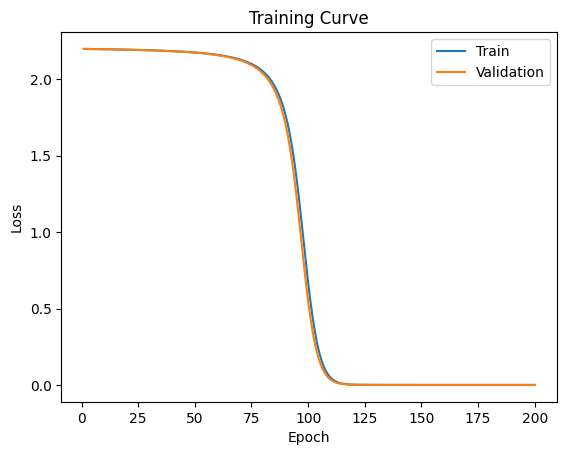

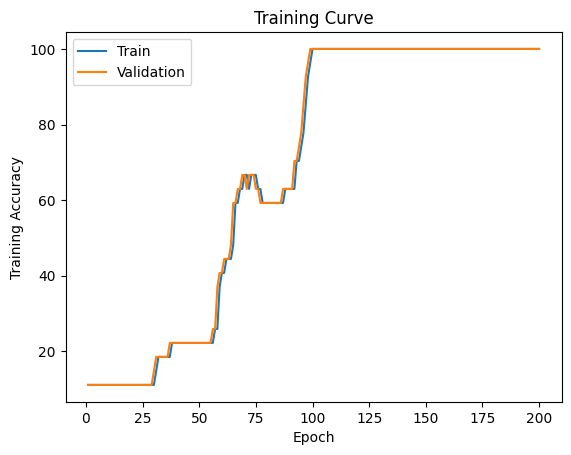

Final Training Accuracy: 100.0
Final Validation Accuracy: 100.0
Best epoch: 199 with validation accuracy: 100.0


In [ ]:
# Overfit to a small dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_loader = train_loader
model = my_CNN().to(device)
train(model, train_loader, val_loader, batch_size=27, learning_rate=0.005, num_epochs=200)


For presenting purpose, here I treated the entire dataset as both training and validation set.
From above we can tell that the model succesfully overfits the training set with a 100% accuracy within 200 iterations.

For the training process, batch size and learning rate are two hyperparameters that most worth tuning.
Proper batch size can accelerate the training process while keeping accuracy at a high level.
Proper learning rate can improve generalization without falling into suboptimal.
One hyperparameter relating to the model architecture that worth to be tuned is the channel number
 in convolutional layers.
Fewer channels can make the training process more stable, but may limit the model's performance.
More channels can improve the model's performance, but may increase the risk of overfitting.

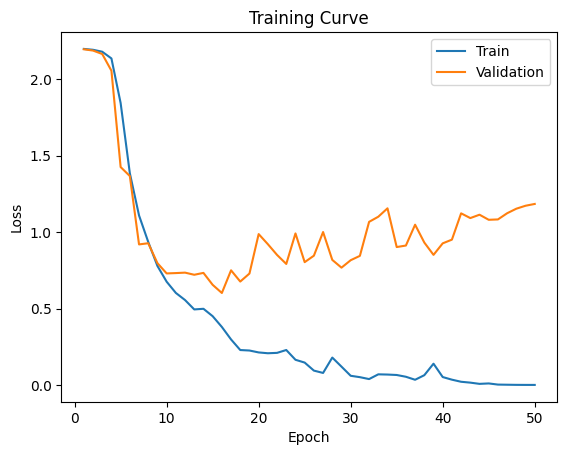

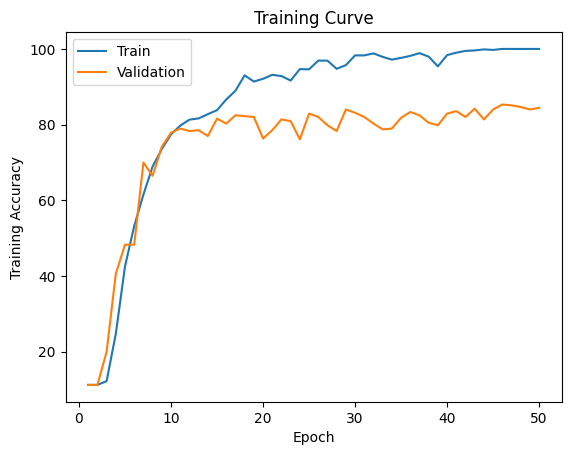

Final Training Accuracy: 100.0
Final Validation Accuracy: 84.4298245614035
Best epoch: 15 with validation accuracy: 80.26315789473684


In [ ]:
# Hyperparameter tuning
data_dir = "./Hand_Gesture_Dataset_revised/Lab_3b_Gesture_Dataset_Revised"  # Path to the dataset directory
batch_size = 128
train_loader, val_loader, test_loader, classes = get_data_loader(
    data_dir=data_dir, batch_size=batch_size
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = my_CNN().to(device)
train(model, train_loader, val_loader, batch_size=128, learning_rate=0.01, num_epochs=50)


Best model: Batch size: 128. Further increasing it will affect the model's performance, while further decreasing it will make the training process more unstable.
Learning rate: 0.01. Further increasing it will not save time significantly (and may cause divergence),
 while further decreasing it will affect the model's performance.
Channel number: 16→32→64. Further increasing it will take longer
 but does not affect the model's performance too much.
Further decreasing it will result in worse performance.
So I decide to keep it unchanged.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate(net, loader, criterion):
  total_loss, total_err, total_samples = 0.0, 0.0, 0
  all_predicted, all_labels = [], []

  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)

      all_predicted.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

      total_err += (predicted != labels).sum().item()
      total_loss += loss.item()
      total_samples += len(labels)

  err = total_err / total_samples
  avg_loss = total_loss / len(loader)

  con_mat = confusion_matrix(all_labels, all_predicted)
  return err, avg_loss, con_mat

<ipython-input-34-d776f5d5baac>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Test accuracy & loss: 0.6236323851203501 1.3240531235933304


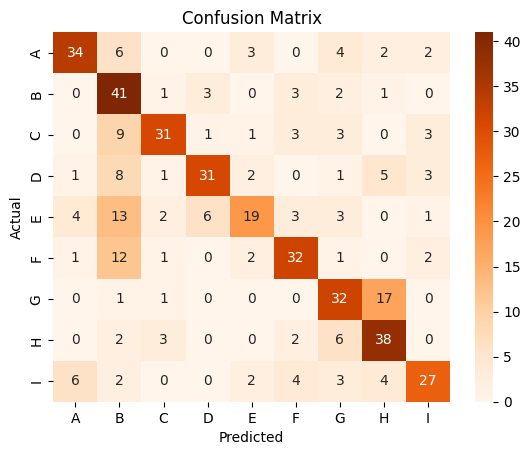

In [ ]:
net = my_CNN().to(device)
model_path = get_model_name('CNN', batch_size=128, learning_rate=0.01, epoch=14)
state = torch.load(model_path)
net.load_state_dict(state)
err, avg_loss, con_mat = evaluate(net, test_loader, criterion=nn.CrossEntropyLoss())
print('Test accuracy & loss:', 1-err, avg_loss)
# Confusion matrix
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Oranges', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Test accuracy I achieved is lower than validation accuracy.
Considering that there are unseen hands in test set, the result is acceptable.
Here I chose the epoch with lowest training loss, as it does not overfit.
From the confusion matrix, we can tell that the model mainly have difficulty
 distinguishing between B and F, and H and G.
That makes sense as they are indeed quite similar gestures and hard to extract features.

In [ ]:
# Transfer learning with AlexNet
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 106MB/s]


In [ ]:
from torch.utils.data import TensorDataset

train_feature, val_feature, test_feature = [], [], []
train_label, val_label, test_label = [], [], []
for img, label in train_loader:
  with torch.no_grad():
    features = alexnet.features(img)
  train_feature.append(features)
  train_label.append(label)
for img, label in val_loader:
  with torch.no_grad():
    features = alexnet.features(img)
  val_feature.append(features)
  val_label.append(label)
for img, label in test_loader:
  with torch.no_grad():
    features = alexnet.features(img)
  test_feature.append(features)
  test_label.append(label)

train_feature = torch.cat(train_feature, dim=0)
val_feature = torch.cat(val_feature, dim=0)
test_feature = torch.cat(test_feature, dim=0)
train_label = torch.cat(train_label, dim=0)
val_label = torch.cat(val_label, dim=0)
test_label = torch.cat(test_label, dim=0)

train_features = TensorDataset(train_feature, train_label)
val_features = TensorDataset(val_feature, val_label)
test_features = TensorDataset(test_feature, test_label)


In [ ]:
# Save the computed features
torch.save(train_features, 'train_feature.pt')
torch.save(val_features, 'val_feature.pt')
torch.save(test_features, 'test_feature.pt')


In [ ]:
# CNN after AlexNet features
class my_CNN_2(nn.Module):
  def __init__(self):
    super(my_CNN_2, self).__init__()
    self.fc1 = nn.Linear(256 * 6 * 6, 512)
    self.fc2 = nn.Linear(512, 9)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


I built a 2-layer network: both layer are fully-connected (fc1, fc2).
Convolutional layer and pooling layer are not used, as AlexNet has already extracted features
 and can play the role of them both.
All I need to do is to flatten the feature maps and feed into fc layers.
ReLU is still used as the activation function after fc1
 to introduce non-linearity and help the network learn complex patterns.
The number of channels increases (256->512) to learn increasingly complex features.
The numbers of hidden units in fc layers are 256, 512, and 9
 to gradually reduces the dimensionality and finalize the classification.

<ipython-input-47-1df7aee06409>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_feature = torch.load('train_feature.pt')
<ipython-input-47-1df7aee06409>:3: FutureWarn

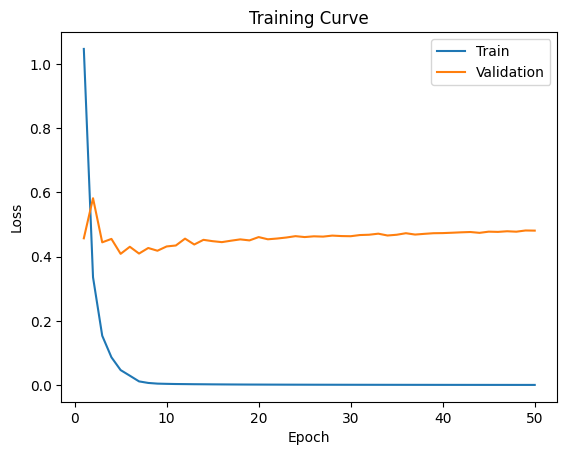

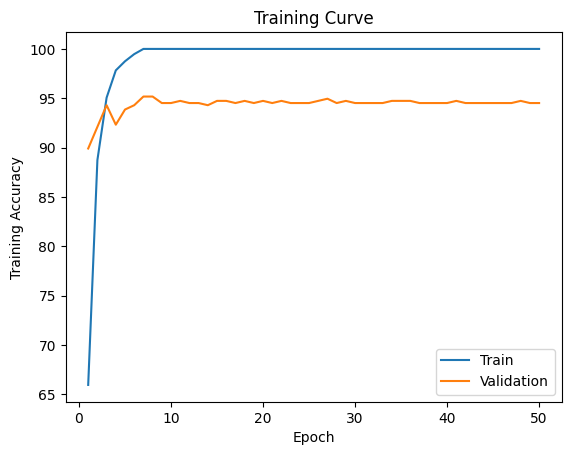

Final Training Accuracy: 100.0
Final Validation Accuracy: 94.51754385964912
Best epoch: 4 with validation accuracy: 93.85964912280701


In [ ]:
# Model training
train_feature = torch.load('train_feature.pt')
val_feature = torch.load('val_feature.pt')
test_feature = torch.load('test_feature.pt')
batch_size=64
train_features = DataLoader(train_feature, batch_size=batch_size, shuffle=True)
val_features = DataLoader(val_feature, batch_size=batch_size, shuffle=False)
test_features = DataLoader(test_feature, batch_size=batch_size, shuffle=False)

model = my_CNN_2().to(device)
train(model, train_features, val_features, batch_size=64, learning_rate=0.01, num_epochs=50, net_name='CNN2')


<ipython-input-48-419af27229c4>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Test accuracy & loss: 0.8468271334792122 0.5110034495592117


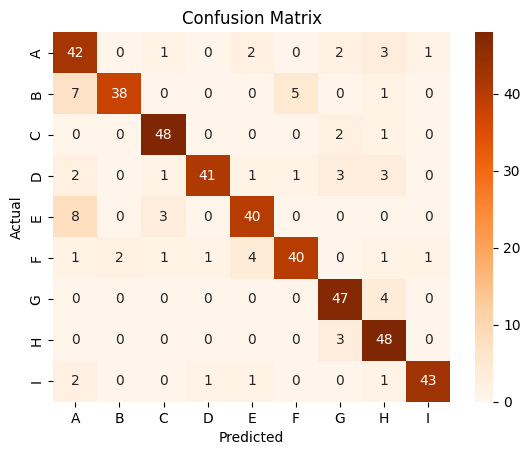

In [ ]:
net = my_CNN_2().to(device)
model_path = get_model_name('CNN2', batch_size=64, learning_rate=0.01, epoch=4)
state = torch.load(model_path)
net.load_state_dict(state)
err, avg_loss, con_mat = evaluate(net, test_features, criterion=nn.CrossEntropyLoss())
print('Test accuracy & loss:', 1-err, avg_loss)
# Confusion matrix
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Oranges', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Test accuracy achieved by this model is much higher comparing to the one without transfer learning (84.68% vs 62.36%).
Comparing two confusion matrices, we can also tell that AlexNet has found some key features
 in telling the difference between similar gestures mentioned above.

In [ ]:
# Transfer learning with ResNet18
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])

train_feature, val_feature, test_feature = [], [], []
train_label, val_label, test_label = [], [], []
for img, label in train_loader:
  with torch.no_grad():
    features = resnet18(img).squeeze()
  train_feature.append(features)
  train_label.append(label)
for img, label in val_loader:
  with torch.no_grad():
    features = resnet18(img).squeeze()
  val_feature.append(features)
  val_label.append(label)
for img, label in test_loader:
  with torch.no_grad():
    features = resnet18(img).squeeze()
  test_feature.append(features)
  test_label.append(label)

train_feature = torch.cat(train_feature, dim=0)
val_feature = torch.cat(val_feature, dim=0)
test_feature = torch.cat(test_feature, dim=0)
train_label = torch.cat(train_label, dim=0)
val_label = torch.cat(val_label, dim=0)
test_label = torch.cat(test_label, dim=0)

train_features = TensorDataset(train_feature, train_label)
val_features = TensorDataset(val_feature, val_label)
test_features = TensorDataset(test_feature, test_label)

torch.save(train_features, 'train_feature_res18.pt')
torch.save(val_features, 'val_feature_res18.pt')
torch.save(test_features, 'test_feature_res18.pt')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# CNN after ResNet18 features
class my_CNN_3(nn.Module):
  def __init__(self):
    super(my_CNN_3, self).__init__()
    self.fc1 = nn.Linear(512, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 9)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


After deleting the last layer of ResNet18, the output tensor shape is Nx512 (after squeezing).
So I built a 3-layer network: all layer are fully-connected (fc1, fc2, fc3),
 to gradually reduce the number of channels (512->256->128->9) so that trivial features are trimmed.
Same as above, I do not need to use more convolutional layer or pooling layer.
ReLU is still used as the activation function after fc1 and fc2 to introduce non-linearity.
The number of hidden units in fc layers are 256, 128, and 9
 to gradually reduces the dimensionality and finalize the classification.

<ipython-input-60-10104b6a346f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_feature = torch.load('train_feature_res18.pt')
<ipython-input-60-10104b6a346f>:3: Futu

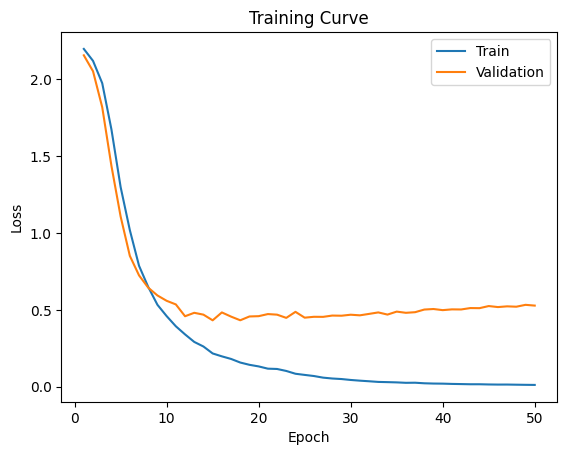

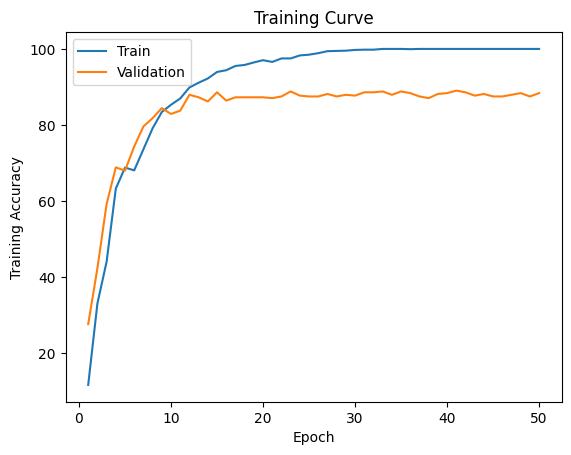

Final Training Accuracy: 100.0
Final Validation Accuracy: 88.37719298245614
Best epoch: 14 with validation accuracy: 88.59649122807018


In [ ]:
# Model training
train_feature = torch.load('train_feature_res18.pt')
val_feature = torch.load('val_feature_res18.pt')
test_feature = torch.load('test_feature_res18.pt')
batch_size=128
train_features = DataLoader(train_feature, batch_size=batch_size, shuffle=True)
val_features = DataLoader(val_feature, batch_size=batch_size, shuffle=False)
test_features = DataLoader(test_feature, batch_size=batch_size, shuffle=False)

model = my_CNN_3().to(device)
train(model, train_features, val_features, batch_size=128, learning_rate=0.01, num_epochs=50, net_name='CNN3')


<ipython-input-62-a942ae2739cd>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Test accuracy & loss: 0.7308533916849016 0.8881510943174362


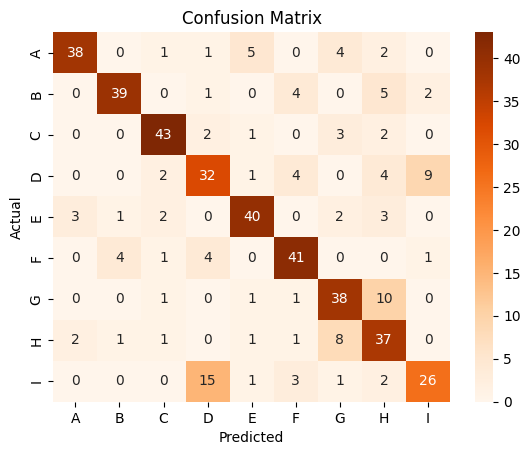

In [ ]:
net = my_CNN_3().to(device)
model_path = get_model_name('CNN3', batch_size=128, learning_rate=0.01, epoch=14)
state = torch.load(model_path)
net.load_state_dict(state)
err, avg_loss, con_mat = evaluate(net, test_features, criterion=nn.CrossEntropyLoss())
print('Test accuracy & loss:', 1-err, avg_loss)
# Confusion matrix
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Oranges', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Comparing to the result achieved by AlexNet, ResNet18 has not performed equally well (Test accuracy: 84.68% vs 73.09%).
But still, the performance is better comparing to my_CNN I designed.
According to test loss, ResNet18 might have overfitted a bit more than AlexNet.
If we take a look at both confusion matrices, we can tell that the gap mainly come from the classification between D and I.
AlexNet can successfully extract features to distinguish them, while ResNet18 has difficulty.
For this task only, AlexNet is the better option.

In [ ]:
# Testing on New Data
data_dir = "./my_gesture"
batch_size = 27
train_loader, val_loader, test_loader, classes = get_data_loader(
    data_dir=data_dir, batch_size=batch_size, test_split=0, valid_split=0, test_new_hands_ratio=0
)
test_loader = train_loader

from torch.utils.data import TensorDataset

test_feature, test_label = [], []
for img, label in test_loader:
  with torch.no_grad():
    features = alexnet.features(img)
  test_feature.append(features)
  test_label.append(label)
test_feature = torch.cat(test_feature, dim=0)
test_label = torch.cat(test_label, dim=0)
test_feat = TensorDataset(test_feature, test_label)
test_features = DataLoader(test_feat, batch_size=batch_size, shuffle=False)

In [ ]:
# Comparison
import pandas as pd

cnn_test_acc, alex_test_acc= 0.623632, 0.846827

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = my_CNN().to(device)
model_path = get_model_name('CNN', batch_size=128, learning_rate=0.01, epoch=14)
state = torch.load(model_path, map_location=torch.device('cpu'))
net.load_state_dict(state)
err, avg_loss, con_mat = evaluate(net, test_loader, criterion=nn.CrossEntropyLoss())
cnn_new_acc = 1-err

net = my_CNN_2().to(device)
model_path = get_model_name('CNN2', batch_size=64, learning_rate=0.01, epoch=4)
state = torch.load(model_path, map_location=torch.device('cpu'))
net.load_state_dict(state)
err, avg_loss, con_mat = evaluate(net, test_features, criterion=nn.CrossEntropyLoss())
alex_new_acc = 1-err

data = [[cnn_test_acc, cnn_new_acc], [alex_test_acc, alex_new_acc]]
index = ['CNN', 'AlexNet']
columns = ['Test set', 'New sample set']
df = pd.DataFrame(data, index=index, columns=columns)
display(df)

<ipython-input-26-68746dd19811>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_location=torch.device('cpu'))
<ipython-input-26-68746dd19

,Test set,New sample set
CNN,0.623632,0.814815
AlexNet,0.846827,1.000000


When it comes to different hand gesture classification, as I mentioned in previous parts,
 AlexNet is better at finding key features for distinguishment,
 while the CNN I designed is more likely to misjudge between certain pairs, according to the confusion matrices.
Both models perform better on the new sample set, while AlexNet achieves perfect accuracy.
This suggests that the set I collected might be easier to classify, possibly due to controlled lighting, clearer gestures, and small size.
The model with AlexNet significantly outperforms the CNN model in both datasets,
 not only by higher accuracy, but by much less time cost as well, which reflects the power of transfer learning.
As a pre-trained model with deeper layers and more proper structure, AlexNet can achieve better generalization and more complex representations,
 while the CNN has only limited capacity and training data.
If I were to apply the models in real-world scenes, they will surely perform worse, with much more noise and more complicated conditions of the images.
There are methods like data augmentation, background removal, further hyperparameter tuning, ensemble learning, and so on to improve the model performance.

In real-world applications, these models may raise many ethical concerns, including bias, privacy, and potential misuse.
Potential biases include hand sizes, skin textures, brightness of background and so on.
Those factors might result in varying performances among different user groups,
 and could lead to miscommunication, unequal experience, or even discrimination if the models are not fully prepared.
During data collection, we should pursue all-encompassing, balanced and accurate labeling dataset.
During training, we should come up with more reasonable evaluation system, like introducing subgroup accuracy.
We may expose the models to users at an early stage and actively make feedback-oriented modifications.

In [ ]:
_ = !unzip "/content/new_gesture.zip" -d "/content/new_gesture/"

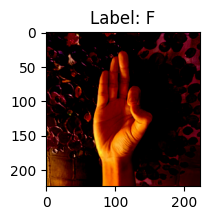

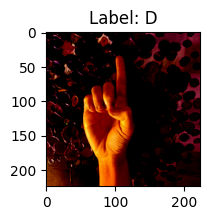

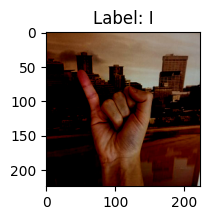

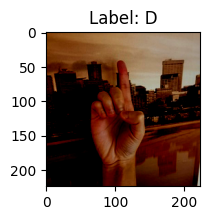

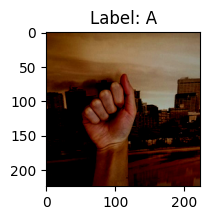

<ipython-input-14-06741ba8770e>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_location=torch.device('cpu'))


Test accuracy & loss: 0.8518518518518519 0.6275644898414612


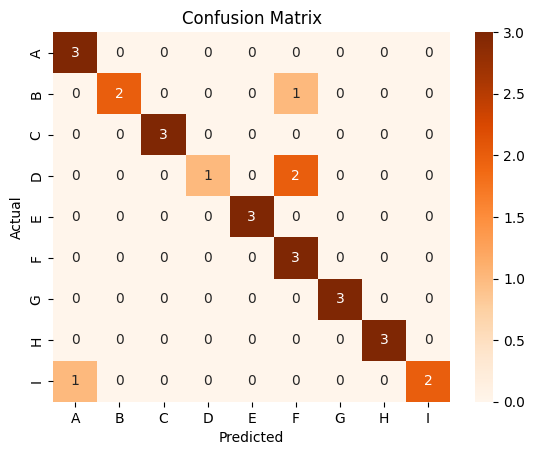

In [ ]:
# Model tested on images with unclean backgrounds

data_dir = "./new_gesture"
batch_size = 27
train_loader, val_loader, test_loader, classes = get_data_loader(
    data_dir=data_dir, batch_size=batch_size, test_split=0, valid_split=0, test_new_hands_ratio=0
)
test_loader = train_loader

# take a look at some images
count = 0
for images, labels in test_loader:
  for i in range(len(images)):
    image = images[i].permute(1, 2, 0).numpy()
    label = classes[labels[i].item()]
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()
    count += 1
    if count >= 5:
      break
  break

from torch.utils.data import TensorDataset

test_feature, test_label = [], []
for img, label in test_loader:
  with torch.no_grad():
    features = alexnet.features(img)
  test_feature.append(features)
  test_label.append(label)
test_feature = torch.cat(test_feature, dim=0)
test_label = torch.cat(test_label, dim=0)
test_feat = TensorDataset(test_feature, test_label)
test_features = DataLoader(test_feat, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = my_CNN_2().to(device)
model_path = get_model_name('CNN2', batch_size=64, learning_rate=0.01, epoch=4)
state = torch.load(model_path, map_location=torch.device('cpu'))
net.load_state_dict(state)
err, avg_loss, con_mat = evaluate(net, test_features, criterion=nn.CrossEntropyLoss())
print('Test accuracy & loss:', 1-err, avg_loss)
# Confusion matrix
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Oranges', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!pip install segment-anything==1.0

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-02-11 02:32:01--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.81, 18.164.78.121, 18.164.78.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  34.8MB/s    in 34s     

2025-02-11 02:32:35 (71.3 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



I took 27 new gesture images with different and unclean background.
This time, the model with AlenNet was not able to achieve perfect performance, but the accuracy was not bad.
Apparently, background of the images will affect the model's ability to recognize the gestures.
But as long as there is contrast or boundary between background and hand, the model can still extract some key features.

In [ ]:
# Data augmentation
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

data_dir = "./A2_Hand_Gesture_Dataset_revised/Lab_3b_Gesture_Dataset Revised"
output_dir = "./segmented_hands"
os.makedirs(output_dir, exist_ok=True)
for subdir in os.listdir(data_dir):
  subdir_path = os.path.join(data_dir, subdir)
  if os.path.isdir(subdir_path):
    for filename in os.listdir(subdir_path):
      if filename.endswith(".jpg"):
        image_path = os.path.join(subdir_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        masks = mask_generator.generate(image)
        largest_mask_index = np.argmax([mask["area"] for mask in masks])
        hand_mask = masks[largest_mask_index]["segmentation"]
        background_path = "./bg.jpg"
        new_background = cv2.imread(background_path)
        new_background = cv2.cvtColor(new_background, cv2.COLOR_BGR2RGB)
        new_background = cv2.resize(new_background, (image.shape[1], image.shape[0]))
        new_image = np.where(np.logical_not(hand_mask[..., None]), image, new_background)
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))
        break # need to be deleted to process all images

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


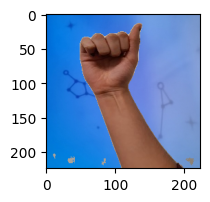

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2, 2))
plt.imshow(new_image)
plt.show()

I followed the code on the internet to try to use the segment anything model to crop hands out of the images.
I made some modifications so that it can process all images in A2_Hand_Gesture_Dataset_revised.
But as it requires almost 10 minutes per image, I only showed one image above.

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 400.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 394.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 833.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-2-11 Python-3.11.11 torch-2.5.1+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


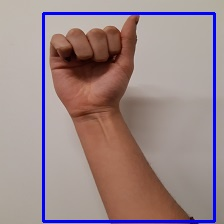

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


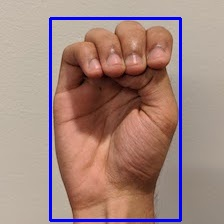

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


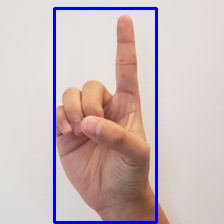

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [ ]:
# Implementation of a region proposal tool
from IPython.display import display, Image

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

data_dir = "./A2_Hand_Gesture_Dataset_revised/Lab_3b_Gesture_Dataset Revised"
output_dir = "./yolo_output"
os.makedirs(output_dir, exist_ok=True)

for subdir in os.listdir(data_dir):
  subdir_path = os.path.join(data_dir, subdir)
  if os.path.isdir(subdir_path):
    for filename in os.listdir(subdir_path):
      if filename.endswith(".jpg"):
        image_path = os.path.join(subdir_path, filename)
        img = cv2.imread(image_path)
        results = model(img)
        if len(results.pandas().xyxy[0]) > 0:
          best_bbox = results.pandas().xyxy[0].loc[results.pandas().xyxy[0]['confidence'].idxmax()]
          cv2.rectangle(img, (int(best_bbox['xmin']), int(best_bbox['ymin'])), (int(best_bbox['xmax']), int(best_bbox['ymax'])), (255, 0, 0), 2)
          display(Image(data=cv2.imencode('.jpg', img)[1].tobytes()))
          output_path = os.path.join(output_dir, filename)
          cv2.imwrite(output_path, img)
        break # need to be deleted to process all images

I imported pretrained YOLOv5 to finish the task.
As shown above, the model can detect hand region correctly.